<a href="https://colab.research.google.com/github/gustvjor2005/catdetection/blob/main/catdetection_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#cat detection
import h5py
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = h5py.File('/content/drive/MyDrive/X-Colab Notebooks/datasets/cat/train_catvnoncat.h5')
test_dataset = h5py.File('/content/drive/MyDrive/X-Colab Notebooks/datasets/cat/test_catvnoncat.h5')

#tamaño 209
t_x = np.array(train_dataset["train_set_x"])/255
t_y = np.array(train_dataset["train_set_y"])
#tamaño 50
ts_x = np.array(test_dataset["test_set_x"])/255
ts_y = np.array(test_dataset["test_set_y"])

ts_xx = torch.tensor(ts_x, dtype=torch.float).view(-1, 64*64*3)
ts_yy = torch.tensor(ts_y, dtype=torch.float).view(ts_x.shape[0],1)

In [ ]:
class Datas(Dataset):

  def __init__(self):
    self.x = torch.tensor(t_x, dtype=torch.float).view(-1, 64*64*3)
    self.y = torch.tensor(t_y, dtype=torch.float).view(t_x.shape[0],1)
    self.len = t_x.shape[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.len

In [ ]:
class Net(nn.Module):

  def __init__(self, i_, h1_, h2_,h3_, out_, p=.0):
    super().__init__()
    self.linear1 = nn.Linear(i_, h1_)
    self.linear2 = nn.Linear(h1_, h2_)
    self.linear3 = nn.Linear(h2_, h3_)
    self.linear4 = nn.Linear(h3_, out_)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = torch.relu(self.linear3(x))
    x = torch.sigmoid(self.linear4(x))
    
    return x

In [ ]:
class Net_drop(nn.Module):

  def __init__(self, i_, h1_, h2_,h3_, out_, p=.0):
    super().__init__()
    self.drop = nn.Dropout(p=p)
    self.linear1 = nn.Linear(i_, h1_)
    self.linear2 = nn.Linear(h1_, h2_)
    self.linear3 = nn.Linear(h2_, h3_)
    self.linear4 = nn.Linear(h3_, out_)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = self.drop(x)
    x = torch.relu(self.linear2(x))
    x = self.drop(x)
    x = torch.relu(self.linear3(x))
    x = self.drop(x)
    x = torch.sigmoid(self.linear4(x))
    
    return x

In [ ]:
class Net_xav(nn.Module):

  def __init__(self, i_, h1_, h2_,h3_, out_, p=.0):
    super().__init__()
    self.linear1 = nn.Linear(i_, h1_)
    torch.nn.init.xavier_uniform_(self.linear1.weight)
    self.linear2 = nn.Linear(h1_, h2_)
    torch.nn.init.xavier_uniform_(self.linear2.weight)
    self.linear3 = nn.Linear(h2_, h3_)
    torch.nn.init.xavier_uniform_(self.linear3.weight)
    self.linear4 = nn.Linear(h3_, out_)
    torch.nn.init.xavier_uniform_(self.linear4.weight)

  def forward(self, x):
    x = torch.tanh(self.linear1(x))
    x = torch.tanh(self.linear2(x))
    x = torch.tanh(self.linear3(x))
    x = torch.sigmoid(self.linear4(x))
    
    return x

In [ ]:
def crit(yhat, y):
  c = -torch.mean(y * torch.log(yhat) + (1 -y) * torch.log(1 -yhat))
  return c

In [ ]:
#dataset
dset = Datas()
#dataloader
dataloader = DataLoader(dataset=dset, batch_size=10)
#criterion
crit = nn.BCELoss()
#modelo
#model = Net(64*64*3, 100, 300, 100, 1, p=.0)
model = Net(64*64*3, 100, 300, 100, 1)

#optimizador
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.2)

In [ ]:
epochs= 450
COST = []
COST_T = []
ACC = []
for i in range(epochs):
  total = 0
  
  model.train()
  model.to(device)
  for x, y in dataloader:
    x, y = x.to(device), y.to(device)
    yhat = model(x)
    loss = crit(yhat, y)
    #print(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total += loss.item()

  accuracy = 0
  total_t = 0
  
  model.eval()
  model.to('cpu')
  for x, y in zip(ts_xx, ts_yy):
    pred = model(x)
    accuracy += (pred > .5).sum()    
    #loss_t = crit(yhat, y)
    #total_t += loss_t.item()
  
  ACC.append(100*accuracy/ts_xx.shape[0])
  COST.append(total)
  #COST_T.append(total_t)
print('Accuracy final ', 100*accuracy/ts_xx.shape[0])

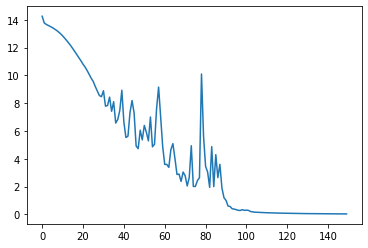

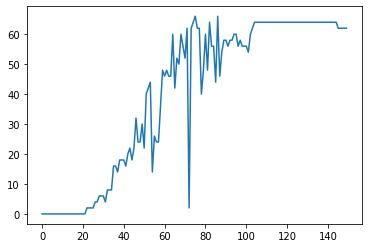

In [ ]:
import matplotlib.pyplot as plt

plt.plot(COST)
plt.show()
plt.plot(ACC)
plt.show()

In [ ]:
n = torch.tensor([1, 2, 3])
nn = torch.tensor([1, 2, 3])


for a, aa in zip(n , nn):
  print(a, aa)

tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(3) tensor(3)
